In [1]:
import torch
import numpy as np
import rasterio
import dl_toolbox.inference as dl_inf
from dl_toolbox.lightning_modules import *
from dl_toolbox.torch_datasets import *


#CKPT_PATH = '/work/OT/ai4usr/fournip/outputs/digi_toulouse_num_train/version_0/checkpoints/epoch=499-step=31499.ckpt'
#CKPT_PATH = '/work/OT/ai4usr/fournip/outputs/semcity_num_train/version_7/checkpoints/epoch=399-step=25199.ckpt'
CKPT_PATH = '/work/OT/ai4usr/fournip/outputs/digitaniev2/ce_d4color3/checkpoints/epoch=428-step=133847.ckpt'
IN_CHANNELS = 3
NUM_CLASSES = 6
ENCODER = 'efficientnet-b5'
#LABEL_PATH = '/work/OT/ai4usr/fournip/miniworld_tif/christchurch/test/10_y.tif'
#LABEL_PATH = '/work/OT/ai4usr/fournip/SemCity-Toulouse-bench/semantic_05/TLS_GT/TLS_GT_01_1.tif'
LABEL_PATH = '/work/OT/ai4usr/fournip/DIGITANIE/Paris/COS9/Paris_9-v4.tif'
#IMAGE_PATH = '/d/pfournie/ai4geo/data/DIGITANIE/Toulouse/toulouse_tuile_6_img_normalized.tif'
#IMAGE_PATH = '/work/OT/ai4usr/fournip/miniworld_tif/christchurch/test/10_x.tif'
IMAGE_PATH = '/work/OT/ai4usr/fournip/DIGITANIE/Paris/Paris_EPSG2154_9.tif'
#IMAGE_PATH = '/work/OT/ai4usr/fournip/SemCity-Toulouse-bench/img_multispec_05/TLS_BDSD_M/TLS_BDSD_M_01.tif'
#FULL_RASTER_PATH = '/d/pfournie/ai4geo/data/DIGITANIE/Toulouse/normalized_mergedTO.tif'
#FULL_RASTER_PATH = '/work/OT/ai4usr/fournip/digitanie/Paris/paris_full_tiled.tif'
TILE = (0, 0, 2000, 2000)
CROP_SIZE = 512
CROP_STEP = 400
LABELS='6'
DATASET = DigitanieV2
#DATASET = SemcityBdsdDs
MODULE = CE
NETWORK='SmpUnet'
ENCODER='efficientnet-b5'
BATCH_SIZE = 8
NUM_WORKERS = 4
TTA = [
    #'hflip', 'vflip', 'd1flip', 'd2flip', 'rot90', 'rot180', 'rot270'
]

/work/OT/ai4usr/fournip/vre_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
window = dl_inf.get_window(TILE)
dataset = DATASET(
    labels=LABELS,
    image_path=IMAGE_PATH,
    #full_raster_path=FULL_RASTER_PATH,
    fixed_crops=True,
    tile=window,
    crop_size=CROP_SIZE,
    crop_step=CROP_STEP,
    img_aug='no'
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(CKPT_PATH, map_location=device)

module = MODULE(
    network=NETWORK,
    in_channels=IN_CHANNELS,
    out_channels=NUM_CLASSES,
    class_names=list(dataset.labels.keys()),
    weights=[1]*NUM_CLASSES,
    pretrained=False,
    encoder=ENCODER,
    ignore_index=-10,
    #final_alpha=1,
    #alpha_milestones=(0),
    #pseudo_threshold=0.9,
)

module.load_state_dict(ckpt['state_dict'])
module.eval()
module.to(device);

In [4]:
probas = dl_inf.compute_probas(
    dataset=dataset,
    module=module,
    batch_size=BATCH_SIZE,
    workers=NUM_WORKERS,
    tta=TTA,
    merge=True,
    device=device
)

batch  0
batch  1
batch  2
batch  3


In [5]:
confs, preds = module._compute_conf_preds(probas.unsqueeze(dim=0))
preds = preds.squeeze().numpy()

In [6]:
labels = dataset.read_label(LABEL_PATH, window=window).astype(np.uint8)
print(dataset.labels)

{'other': {'color': (0, 0, 0)}, 'low_vegetation': {'color': (0, 250, 50)}, 'water': {'color': (0, 50, 250)}, 'building': {'color': (250, 50, 50)}, 'high_vegetation': {'color': (0, 100, 50)}, 'road': {'color': (100, 100, 100)}}


                       F1    Recall  Precision       IoU
other            0.644639  0.640997   0.648322  0.475621
low_vegetation   0.654825  0.668382   0.641807  0.486795
water            0.743888  0.990541   0.595582  0.592214
building         0.795319  0.847351   0.749308  0.660191
high_vegetation  0.563501  0.589619   0.539599  0.392274
road             0.567763  0.484289   0.686006  0.396417
    macroF1  macroRecall  macroPrecision  macroIoU  OAccuracy     Kappa
0  0.661656      0.70353        0.643437  0.500585   0.662104  0.558881
    microF1  microRecall  microPrecision  microIoU
0  0.662104     0.662104        0.662104  0.494885


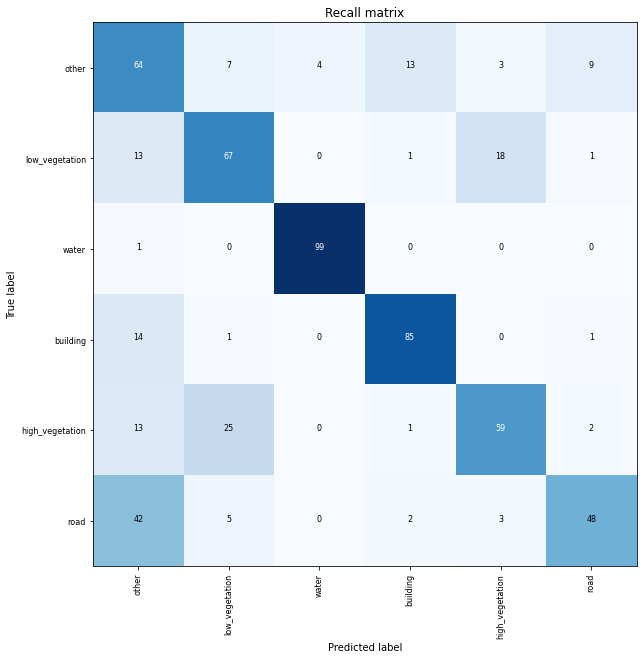

In [8]:
%matplotlib inline

from dl_toolbox.callbacks import plot_confusion_matrix, compute_conf_mat

cm = compute_conf_mat(
    torch.tensor(labels).flatten().cpu(),
    torch.tensor(preds).flatten().cpu(),
    NUM_CLASSES
)

metrics_per_class_df, macro_average_metrics_df, micro_average_metrics_df = dl_inf.cm2metrics(cm.numpy())
metrics_per_class_df.rename(
    index=dict([(i, l) for i, l in enumerate(dataset.labels.keys())]),
    inplace=True
)

print(metrics_per_class_df)
print(macro_average_metrics_df)
print(micro_average_metrics_df)

fig = plot_confusion_matrix(cm.cpu(), class_names=dataset.labels.keys(), norm='recall')
fig.show()

#fig = plt.figure(figsize=(20,20))
#subfigs = fig.subfigures(2,1, wspace=0.02)
#subfigs[0] = plot_confusion_matrix(confmat_recall.numpy(), class_names=dataset.labels.keys())
#subfigs[1] = plot_confusion_matrix(confmat_prec.numpy(), class_names=dataset.labels.keys())
#plt.show()

#confmat_recall_fig = plot_confusion_matrix(confmat_recall.numpy(), class_names=dataset.labels.keys())
#plt.title('Recall')
#plt.show()

#confmat_prec_fig = plot_confusion_matrix(confmat_prec.numpy(), class_names=dataset.labels.keys())
#plt.title('Precision')
#plt.show()

#subfigs[1].suptitle('Precision')

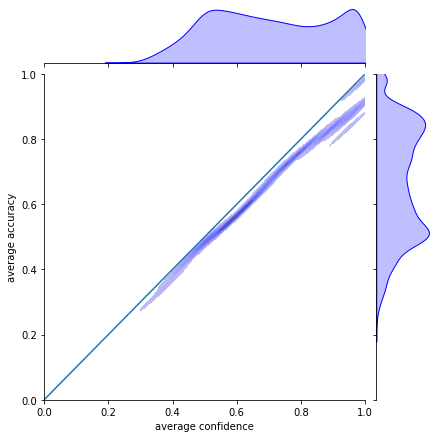

In [9]:
%matplotlib inline

from dl_toolbox.callbacks import plot_calib, compute_calibration_bins

acc_bins, conf_bins, count_bins = compute_calibration_bins(
    torch.linspace(0, 1, 100 + 1),
    torch.tensor(labels).flatten().cpu(),
    confs.flatten().cpu(),
    torch.tensor(preds).flatten().cpu(),
    ignore_idx=None
)

calib_fig = plot_calib(
    count_bins.numpy(),
    acc_bins.numpy(),
    conf_bins.numpy(),
    max_points=10000
)

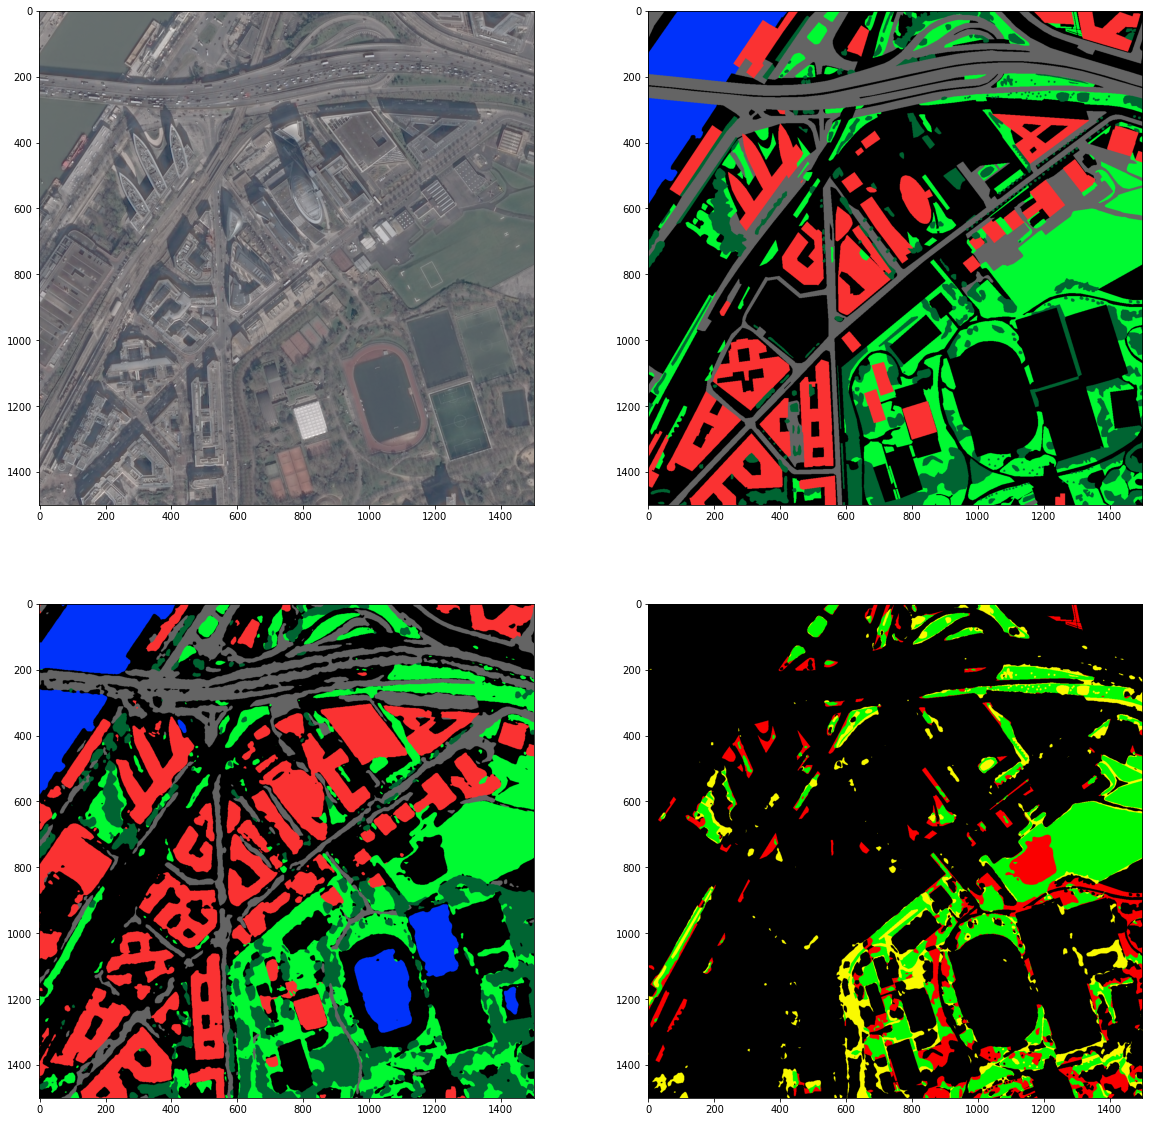

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
from skimage import exposure
from dl_toolbox.utils import LabelsToRGB

zone = np.s_[0:1500, 0:1500, ...]

image = dataset.read_image(
    image_path=IMAGE_PATH,
    window=window
)
image = image.transpose(1,2,0)
image = exposure.adjust_gamma(image, 0.3)

overlay = np.zeros(shape=(window.height, window.width, 3), dtype=np.uint8)
label_bool = labels == 1
pred_bool = preds == 1

# Correct predictions (Hits) painted with green
overlay[label_bool & pred_bool] = np.array([0, 250, 0], dtype=overlay.dtype)
# Misses painted with red
overlay[label_bool & ~pred_bool] = np.array([250, 0, 0], dtype=overlay.dtype)
# False alarm painted with yellow
overlay[~label_bool & pred_bool] = np.array([250, 250, 0], dtype=overlay.dtype)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax1.imshow(image[zone])
ax2 = fig.add_subplot(222)
ax2.imshow(LabelsToRGB(dataset.labels)(labels)[zone])
ax3 = fig.add_subplot(223)
ax3.imshow(LabelsToRGB(dataset.labels)(preds)[zone])
ax4 = fig.add_subplot(224)
ax4.imshow(overlay[zone])

In [ ]:
initial_profile = rasterio.open(IMAGE_PATH).profile
OUTPUT = 
#rgb = DigitanieToulouseDs.labels_to_rgb(preds)

dl_inf.write_array(
    inputs=probas,
    tile=TILE,
    output_path=args.output_probas,
    profile=initial_profile
)

In [ ]:
import pydensecrf.densecrf as dcrf

probas_class = probas[1,...]
probas_crf = np.vstack([1-probas_class, probas_class])
unary = -np.log(probas_crf).reshape((2, -1)).astype(np.float32)
d = dcrf.DenseCRF2D(2000, 2000, 2)
d.setUnaryEnergy(unary)
d.addPairwiseGaussian(sxy=3, compat=3)
Q = d.inference(10)
MAP = np.argmax(Q, axis=0)
preds_crf = MAP.reshape((2000,2000))
preds_basic = probas[4,...] > 0.5